<a href="https://colab.research.google.com/github/JorgeCarmona323/Macrocycle/blob/main/LCMS_Analysis_and_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# ============================================================================
# INTEGRATED LC-MS ANALYSIS - FULL SCRIPT
# Plot UV chromatogram (top) with mass spectrum (bottom) as SVG
# ============================================================================

print("Installing required packages...")
!pip install -q pymzml pandas matplotlib scipy peakutils numpy

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pandas as pd
import numpy as np
import pymzml
import scipy.signal
import peakutils
import matplotlib.pyplot as plt
import math

Installing required packages...
Mounted at /content/drive


In [41]:
# ============================================================================
# UTILITY FUNCTION
# ============================================================================

def truncate(number, digits):
    """Truncate number to specified decimal places"""
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [42]:
# ============================================================================
# READ CHROMELEON UV DATA
# ============================================================================

def read_chromeleon_uv(txt_file):
    """
    Read Chromeleon UV-VIS .txt file
    Tries multiple header configurations
    """
    for header_row in [22, 31, 38]:
        try:
            df = pd.read_csv(txt_file, sep='\t', header=header_row)
            if 'Value (mAU)' in df.columns:
                return df
        except:
            continue

    # Try comma separator
    for header_row in [22, 31, 38]:
        try:
            df = pd.read_csv(txt_file, sep=',', header=header_row)
            if 'Intensity' in df.columns or 'Value (mAU)' in df.columns:
                return df
        except:
            continue

    raise ValueError(f"Could not read {txt_file}. Check file format.")

In [43]:
# ============================================================================
# EXTRACT MS DATA FROM mzML
# ============================================================================

def extract_all_ms_timeseries(mzml_file):
    """
    Extract intensity vs time for all m/z values
    Returns: DataFrame with time, mz, intensity columns
    """
    print(f"Extracting all MS data from {os.path.basename(mzml_file)}...")

    timeseries = []
    run = pymzml.run.Reader(mzml_file, skip_chromatogram=False)

    for entry in run:
        if isinstance(entry, pymzml.spec.Spectrum):
            try:
                rt = truncate(entry.scan_time[0], 3)

                for mz, intensity in entry.peaks("raw"):
                    timeseries.append({
                        'Time_min': rt,
                        'MZ': truncate(mz, 3),
                        'Intensity': truncate(intensity, 2)
                    })
            except:
                continue

    df = pd.DataFrame(timeseries)
    print(f"  ✓ Extracted {len(df)} data points")
    return df

In [44]:
# ============================================================================
# PEAK DETECTION & ANALYSIS
# ============================================================================

def analyze_chromatogram(chrom_df, peak_threshold=0.1, start_time=0):
    """
    Detect peaks in UV chromatogram
    Returns: (times, intensities, peak_indices, peak_data)
    """
    # Handle different column names
    if 'Value (mAU)' in chrom_df.columns:
        value_col = 'Value (mAU)'
        time_col = 'Time (min)'
    elif 'Intensity' in chrom_df.columns:
        value_col = 'Intensity'
        time_col = 'R.Time (min)'
    else:
        raise ValueError("Could not identify intensity or time columns")

    # Clean data
    if chrom_df[value_col].dtype == str or chrom_df[value_col].dtype == object:
        chrom_df[value_col] = chrom_df[value_col].str.replace(",", "").astype(float)

    # Extract after start_time
    tempx, tempy = [], []
    for i, t in enumerate(chrom_df[time_col]):
        if t > start_time:
            tempx.append(t)
            tempy.append(float(chrom_df[value_col].iloc[i]))

    x = np.array(tempx)
    y = np.array(tempy)

    # Peak detection
    if max(y) > 5:
        indexes = peakutils.indexes(y, thres=peak_threshold, min_dist=10)
    else:
        indexes = peakutils.indexes(y, thres=2, thres_abs=True)

    widths = scipy.signal.peak_widths(y, indexes)

    # Calculate peak data
    peak_total = sum(y)
    peak_data = {}
    for i, j in enumerate(widths[0]):
        idx_low = max(0, indexes[i] - int(j))
        idx_high = min(len(y)-1, indexes[i] + int(j))
        peak_data[indexes[i]] = {
            'rt': x[indexes[i]],
            'intensity': y[indexes[i]],
            'area': sum(y[idx_low:idx_high+1]) / peak_total * 100,
            'width': j
        }

    return x, y, indexes, peak_data

In [45]:
# ============================================================================
# GET CLOSEST SPECTRUM AT RETENTION TIME
# ============================================================================

def get_closest_spectrum_at_rt(ms_df, target_rt, tolerance=0.3):
    """
    Get mass spectrum closest to target retention time

    Returns: (spectrum_dataframe, closest_rt)
    """
    # Filter to time window around target
    window = ms_df[(ms_df['Time_min'] >= target_rt - tolerance) &
                   (ms_df['Time_min'] <= target_rt + tolerance)]

    if window.empty:
        return pd.DataFrame(), target_rt

    # Get unique times and find closest
    unique_times = window['Time_min'].unique()
    closest_rt = min(unique_times, key=lambda t: abs(t - target_rt))

    # Extract that spectrum
    spectrum = window[window['Time_min'] == closest_rt][['MZ', 'Intensity']].drop_duplicates()

    # Rename for output
    spectrum.columns = ['MZ', 'Intensity']

    return spectrum, closest_rt

In [46]:
# ============================================================================
# PLOTTING FUNCTION
# ============================================================================

def plot_peak_with_mass_spectrum(x_uv, y_uv, peak_idx, peak_data, ms_df, output_dir,
                                sample_name, wavelength="280nm", rt_offset=0.0):
    """
    Plot UV peak on top and mass spectrum on bottom (SVG format)

    Args:
        x_uv, y_uv: UV chromatogram data
        peak_idx: index of peak in x_uv array
        peak_data: dict with peak info
        ms_df: DataFrame with Time_min, MZ, Intensity
        output_dir: output directory
        sample_name: sample name
        wavelength: wavelength for UV
        rt_offset: retention time offset to apply to MS data
    """

    rt_peak = x_uv[peak_idx]
    peak_info = peak_data[peak_idx]

    # Define retention time window (±50% of peak width)
    peak_width_min = peak_info['width'] / len(x_uv) * (x_uv[-1] - x_uv[0])
    rt_start = max(rt_peak - peak_width_min * 0.75, x_uv[0])
    rt_end = min(rt_peak + peak_width_min * 0.75, x_uv[-1])

    # Apply offset to MS retention time for alignment
    rt_peak_ms = rt_peak + rt_offset

    print(f"  Peak {peak_idx}: UV RT {rt_peak:.2f} min, MS RT {rt_peak_ms:.2f} min (offset: {rt_offset:+.3f})")

    # Get mass spectrum at peak retention time
    spectrum_at_peak, closest_rt = get_closest_spectrum_at_rt(ms_df, rt_peak_ms, tolerance=0.3)

    if spectrum_at_peak.empty:
        print(f"    ⚠ No MS data found near RT {rt_peak_ms:.2f}")
        return None

    # Create figure with 2 subplots (UV on top, MS on bottom)
    fig, (ax_uv, ax_ms) = plt.subplots(2, 1, figsize=(14, 10),
                                        gridspec_kw={'height_ratios': [1, 1]})

    # ====== TOP PLOT: UV CHROMATOGRAM ======

    # Plot full chromatogram
    ax_uv.plot(x_uv, y_uv, color='grey', linewidth=2.5, label='UV Chromatogram')
    ax_uv.set_xlabel("Retention Time (min)", fontsize=12, weight='bold')
    ax_uv.set_ylabel("Intensity (mAU)", fontsize=12, weight='bold')
    ax_uv.set_title(f"{sample_name} at RT {rt_peak:.2f} min ({wavelength})",
               fontsize=13, weight='bold')
    ax_uv.grid(True, alpha=0.3)
    ax_uv.legend(loc='upper right', fontsize=10)
    ax_uv.tick_params(axis='both', which='both', length=0)
    ax_uv.set_facecolor('white')
    for spine in ['top', 'bottom', 'left', 'right']:
        ax_uv.spines[spine].set_linewidth(2)

    # ====== BOTTOM PLOT: MASS SPECTRUM ======

    mz = np.asarray(spectrum_at_peak['MZ'], dtype=float)
    intensity = np.asarray(spectrum_at_peak['Intensity'], dtype=float)

    # Bar plot for mass spectrum
    bars = ax_ms.bar(mz, intensity, width=1, color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.5)

    # Label top peaks (>20% of max intensity)
    threshold = 0.2
    y_lab = np.argwhere(intensity > np.amax(intensity) * threshold)
    for i in y_lab:
        mz_val = truncate(float(mz[i]), 2)
        ax_ms.annotate(f'{mz_val}', (mz[i], intensity[i]),
                      textcoords="offset points", xytext=(0, 5),
                      ha='center', fontsize=9, weight='bold')

    ax_ms.set_xlabel("Mass Range (m/z)", fontsize=12, weight='bold')
    ax_ms.set_ylabel("Ion Counts (mAU)", fontsize=12, weight='bold')
    ax_ms.set_title(f"Mass Spectrum at Peak {peak_idx}",
                   fontsize=13, weight='bold')
    ax_ms.set_xlim(150, 1200)
    ax_ms.grid(True, alpha=0.3, axis='y')
    ax_ms.tick_params(axis='both', which='both', length=0)
    ax_ms.set_facecolor('white')
    for spine in ['top', 'bottom', 'left', 'right']:
        ax_ms.spines[spine].set_linewidth(2)

    plt.tight_layout()

    # Save as SVG
    output_path = os.path.join(output_dir,
                              f"{sample_name}_Peak{peak_idx}_RT{rt_peak:.2f}min.svg")
    plt.savefig(output_path, format='svg', bbox_inches='tight')
    print(f"    ✓ Saved SVG: {os.path.basename(output_path)}")
    plt.show()

    return spectrum_at_peak

In [47]:
# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def analyze_peaks_with_ms_traces(uv_txt_file, mzml_file, output_dir,
                                sample_name="Sample", wavelength="280nm",
                                peak_threshold=0.3, peaks_to_analyze=None, rt_offset=0.0):
    """
    Main analysis: plot UV peaks with coinciding mass spectra

    Args:
        uv_txt_file: path to Chromeleon UV .txt file
        mzml_file: path to mzML file
        output_dir: output directory
        sample_name: sample name
        wavelength: UV wavelength
        peak_threshold: threshold for peak detection
        peaks_to_analyze: list of peak indices to analyze (None = all)
        rt_offset: retention time offset in minutes to align UV and MS
    """

    print("\n" + "="*70)
    print(f"LC-MS ANALYSIS: {sample_name}")
    print("="*70 + "\n")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Read UV data
    print(f"Reading UV chromatogram: {os.path.basename(uv_txt_file)}")
    chrom_df = read_chromeleon_uv(uv_txt_file)

    # Analyze chromatogram
    x_uv, y_uv, indexes, peak_data = analyze_chromatogram(
        chrom_df, peak_threshold=peak_threshold, start_time=0
    )

    print(f"✓ Detected {len(indexes)} UV peaks\n")

    # Extract all MS data
    print(f"Reading MS data: {os.path.basename(mzml_file)}")
    ms_df = extract_all_ms_timeseries(mzml_file)

    if ms_df.empty:
        print("✗ No MS data found in mzML file")
        return None

    print()

    # Analyze specific peaks or all peaks
    if peaks_to_analyze is None:
        peaks_to_analyze = list(indexes)

    results = []

    for peak_idx in peaks_to_analyze:
        if peak_idx not in peak_data:
            print(f"⚠ Peak {peak_idx} not found")
            continue

        spectrum = plot_peak_with_mass_spectrum(
            x_uv, y_uv, peak_idx, peak_data, ms_df, output_dir,
            sample_name, wavelength, rt_offset=rt_offset
        )

        if spectrum is not None and not spectrum.empty:
            peak_info = peak_data[peak_idx]

            # Get top m/z values from spectrum
            spectrum_sorted = spectrum.sort_values('Intensity', ascending=False)
            top_mz = ', '.join([f"{mz:.2f}" for mz in spectrum_sorted['MZ'].head(3)])

            results.append({
                'Peak': peak_idx,
                'RT_min': truncate(peak_info['rt'], 2),
                'UV_Intensity_mAU': truncate(peak_info['intensity'], 1),
                'Peak_Area_percent': truncate(peak_info['area'], 2),
                'Top_3_m_z': top_mz
            })

    # Create results dataframe
    df_results = pd.DataFrame(results)

    # Save results
    csv_path = os.path.join(output_dir, f"Analysis_{sample_name}.csv")
    df_results.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved: {csv_path}\n")

    print("="*70)
    print(df_results.to_string(index=False))
    print("="*70)

    return df_results

In [48]:
# ============================================================================
# USAGE - UPDATE THESE PATHS!
# ============================================================================

if __name__ == "__main__":

    # ====================================================================
    # CONFIGURATION - UPDATE THESE VALUES FOR YOUR DATA
    # ====================================================================

    # Path to your UV_VIS_1.txt file
    uv_file = '/content/drive/MyDrive/Brain-Ala-4-4-13_PURE_20251114.txt'

    # Path to your converted mzML file
    mzml_file = '/content/drive/MyDrive/X1_MS_RAW.mzML'

    # Where to save output SVG files and CSV
    output_dir = '/content/drive/MyDrive/X1_Analysis_Results'

    # Sample name (for output files)
    sample_name = "Brain Ala-4-4-13"

    # UV wavelength (from your file)
    wavelength = "214nm"

    # RETENTION TIME OFFSET (critical for alignment!)
    # If UV peak at 4.07 min and MS peak at 4.12 min, set rt_offset = 0.05
    rt_offset = 0.1  # CHANGE THIS VALUE to align your peaks!


LC-MS ANALYSIS: Brain Ala-4-4-13

Reading UV chromatogram: Brain-Ala-4-4-13_PURE_20251114.txt
✓ Detected 1 UV peaks

Reading MS data: X1_MS_RAW.mzML
Extracting all MS data from X1_MS_RAW.mzML...
  ✓ Extracted 1876237 data points

  Peak 1220: UV RT 4.07 min, MS RT 4.17 min (offset: +0.100)


/tmp/ipython-input-645338901.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mz_val = truncate(float(mz[i]), 2)


    ✓ Saved SVG: Brain Ala-4-4-13_Peak1220_RT4.07min.svg


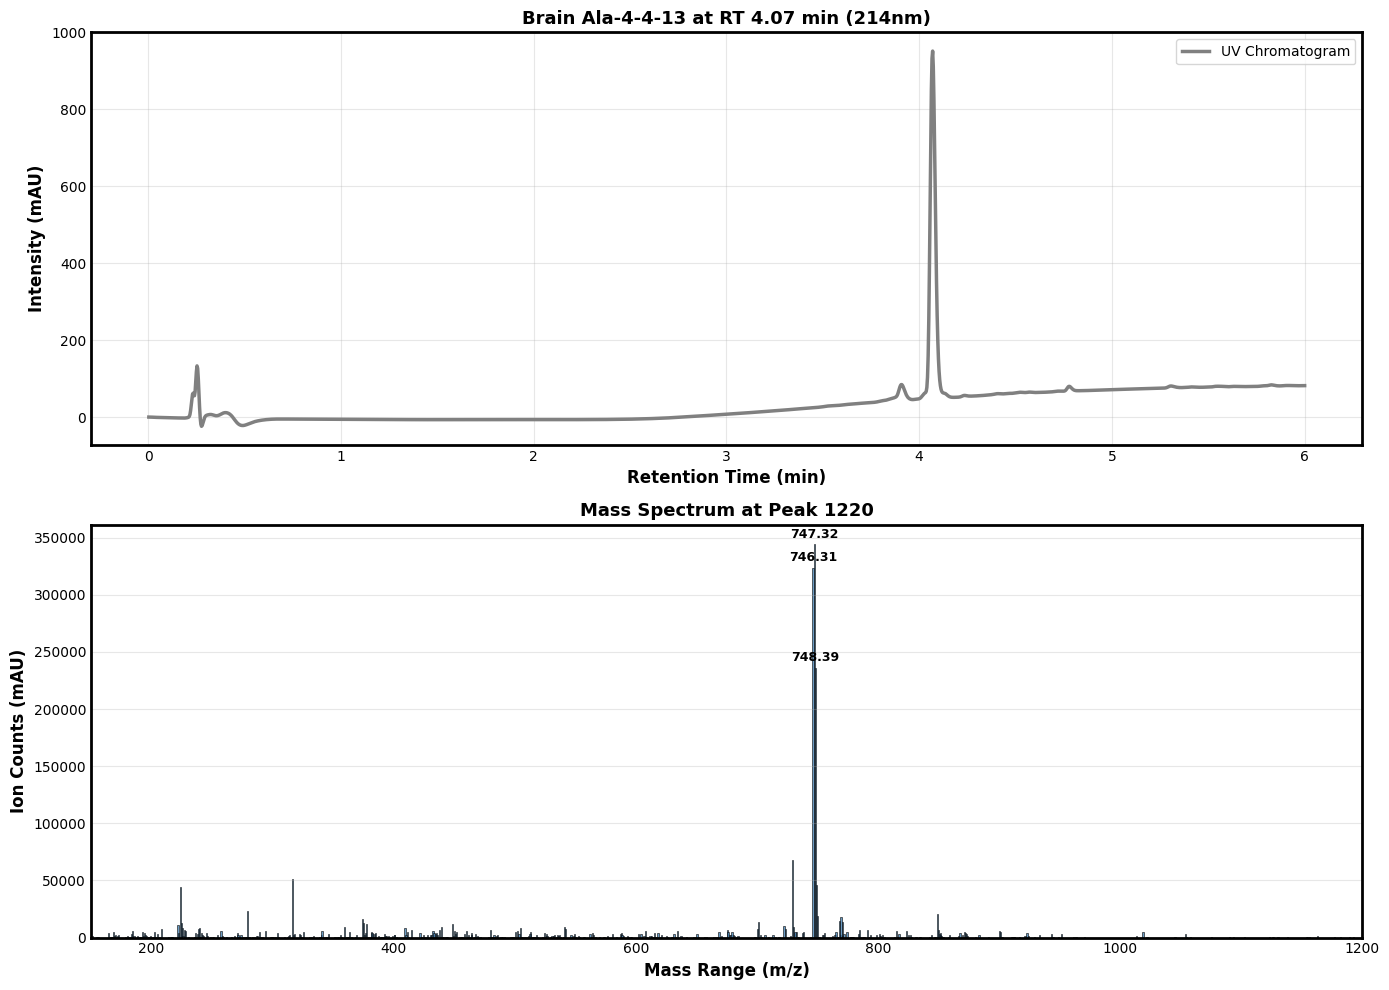


✓ Results saved: /content/drive/MyDrive/X1_Analysis_Results/Analysis_Brain Ala-4-4-13.csv

 Peak  RT_min  UV_Intensity_mAU  Peak_Area_percent              Top_3_m_z
 1220    4.07             951.8              16.36 747.32, 746.31, 748.39


In [49]:
    # ===================================================================
    # RUN ANALYSIS
    # ====================================================================

    # Analyze ALL peaks
    results = analyze_peaks_with_ms_traces(
        uv_txt_file=uv_file,
        mzml_file=mzml_file,
        output_dir=output_dir,
        sample_name=sample_name,
        wavelength=wavelength,
        peak_threshold=0.3,
        peaks_to_analyze=None,  # None = all peaks
        rt_offset=rt_offset
    )

    # Or analyze SPECIFIC peaks only:
    # results = analyze_peaks_with_ms_traces(
    #     uv_txt_file=uv_file,
    #     mzml_file=mzml_file,
    #     output_dir=output_dir,
    #     sample_name=sample_name,
    #     wavelength=wavelength,
    #     peaks_to_analyze=[0, 1, 2],  # Only peaks 0, 1, 2
    #     rt_offset=rt_offset
    # )